## Conditional Probability 

Conditioning updates probabilities by incorporating (partial) information in the form of conditioning events. The conditioning operation is crucial for virtually every application of probability theory, but this notebook will focus on [Information Theory](https://en.wikipedia.org/wiki/Information_theory) and, more specifically, [Channel Coding (a.k.a. Error Detection and Correction)](https://en.wikipedia.org/wiki/Error_detection_and_correction). This is the study of *codes* for communicating over noisy channels, and has applications anywhere from WiFi to computer memory devices. Interestingly, the performance, and hence design, of such codes relies crucialy on probability theory.

####  Binary Symmetric Channel

Assume the basic channel coding setup: Alice wants to transmit a "message" to Bob over over a *binary* channel (e.g. wire with on=1/off=0 states). The message could be anything (e.g. a number, word, or image), but it has to be *encoded* into a binary string for sending over the channel. Similarly, Bob has to *decode* the binary string he receives to convert it back to the original message. The convention for encodind and decoding is called the [code](https://en.wikipedia.org/wiki/Code).

<a title="Benjamin D. Esham, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Binary_symmetric_channel_(en).svg"><img width="512" alt="Binary symmetric channel (en)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Binary_symmetric_channel_%28en%29.svg/512px-Binary_symmetric_channel_%28en%29.svg.png"></a>

If the communication channel was perfect, the choice of code would be straightforward: we would use the most succinct (i.e. shortest) mapping of messages to binary strings. But the channel is "noisy" and can randomly change states with equal probability $p$ of switching from 0 to 1, and vice-versa; this classical setup is called the [binary symmetric channel](https://en.wikipedia.org/wiki/Binary_symmetric_channel). 

#### Binary Representation Code

To fix ideas, assume the message is a digit in 0-9, and that all digits are equally likely. In other words, without receiving *any* message (no information) Bob would expect a digit in 0-9 with equal probability. Each message is then *encoded* into a binary sequence of 0's and 1' according to *some* encoding function $E()$. The coded message is then transmitted over the channel, and Bob receives a (possibly corrupted) signal, which is then *decoded* into a message or an error ($err$), according to the decoding function $D()$. There are different ways to treat errors, depending on whether the channel allows for two-way communication (e.g. Bob can request a repeat if he gets an error), but to keep things simple we assume only one-way communication. 

To fix ideas, let our coding scheme map the 10 messages/digits, denoted $M_i,\; i=0,\ldots,9$  onto their classical binary representation, i.e. $E(0)=(0000)$, $E(1)=(0001)$, up to $E(9)=(1001)$. We use strings of length 4 because we need at least $\log_2(10) = 3.3219$ bits to represent 10 numbers. This leaves us with $2^4-10=6$ unused strings, which the decoder maps to an error; the entire coding scheme is represented below:
![Naive Code](./img/3/naive_code.svg)

##### Conditional Probabilities

Note that there are two sources of randomnes, represented in red:
1. the choice of message (from the perspective of Bob, who doesn't know Alice's intentions), and 
2. the noisy transmission. 

The encoding and decoding are deterministic 1-to-1 functions (black arrows). Without information (i.e. received code), Bob knows that every message (digit) is equally likely to be chosen by Alice. Let's represent this by assigning events $M_0,\ldots,M_9$ for each digit, where $P(M_i)=.1, \;  i=0,\ldots,9$.

When Bob obtains information in the form of the received code $R_j$, he updates the message probabilities accordingly. He is now interested in $P(M_i|R_j)$, but this probability is not directly available. 

Nevertheless, we know $P(R_j|M_i)$ from the binary symmetric channel assumption, since the probability of any error (flipped bit) is $p$, independently of other errors. For example, for message $M_1=\{1\}$ with $E(M_1)=(0001)$ the probability of receiving code $(0100)$ ($R_4$) is $p^2 \times (1-p)^{4-2}$, because the codes differ by 2 bits, so there were 2 errors and 4-2=2 correct bits (their location is irrelevant). More generally, we have: 

$$ P(R_j | M_i ) = p^{ d_{ham} ( E(M_i), R_j )  } \times (1-p)^{ 4 - d_{ham} ( E(M_i), R_j ) } $$

where $d_{ham}(\cdot, \cdot)$ is the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance), i.e. the number of differring characters in two strings of the same length. Assuming the transmission error probability is $p=5\%$, we can calculate *all* conditional probabilities of the form $P( R_j | M_i ),\; j=0,\ldots,9, \; i = 0,\ldots, 15$ in the $10 \times 16$ matrix ```P_RgM```, where the row index represents the message, and the column index the received code. 

In [18]:
import numpy as np

# List of all possible codes
codes = []
for j in np.arange(2**4):
    codes.append( np.binary_repr(j, width = 4) )  
    
# Hamming distance function (from https://en.wikipedia.org/wiki/Hamming_distance)    
def hamming(string1, string2): 
    dist_counter = 0
    for n in range(len(string1)):
        if string1[n] != string2[n]:
            dist_counter += 1
    return dist_counter

# Distance matrix of all codes
dist_mat = np.ones( [ len(codes), len(codes) ] )
for i in range(len(codes)):
    for j in range(len(codes)):
        dist_mat[i,j] = hamming( codes[i], codes[j] )

p = .05 # transmission error probability
        
# We use only the relevant rows (first 10) of the distance matrix 
# to caclulate the conditional probabilites 
P_RgM = ( p ** dist_mat[0:10,:] ) * ( (1-p) ** ( 4 - dist_mat[0:10,:] ) )

The rows of ```P_RgM``` sum to 1, since each row represents a conditional probability measure, conditional on the (encoded) message.

In [19]:
np.sum( P_RgM, axis = 1 ) # take row sums of matrix P_RgM

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We can now answer questions such as: *If Bob received $R_4=(0100)\rightarrow D(R_4)=4$, what is the probability that Alice actually sent $M_4 = \{4\}$ ?*, (This is an extension of Execise 2.12.(a) from [B&W](https://drive.google.com/file/d/1VmkAAGOYCTORq1wxSQqy255qLJjTNvBI/view)). 
![Bayes for coding](./img/3/binary_repr_code_bayes.svg)
We are looking for $P(M_4|R_4)$ but we know $P(R_4|M_i)$ and $P(M_i)$ for all $i=0,\ldots,9$, which is exactly the setup for *Bayes rule*:

$$ P(M_i|R_j) = \frac{ P(R_j|M_i) P(M_i) }{ P( R_j) } = \frac{ P(M_i \cap R_j) }{ \sum_{i}  P( M_i \cap R_j) } $$

The main ingredient in both numerator and denominator are the *joint* probabilities $P(M_i \cap R_j) = P(R_j|M_i) P(M_i)$, which are found by multiplying each element of the conditional probability matrix with the appropriate message probability. In our case, since all messages are equally likely, we can just multiply every element of ```P_RgM``` by 0.1.

In [20]:
P_MR = P_RgM * .1

The probability $P(M_4|R_4) = \frac{ P(M_4 \cap R_4) } { \sum_{i=0}^{9} P(M_i, R_4) } $ is 

In [21]:
P_MR[4,4] / sum( P_MR[:,4] )

0.8552369077306735

We can look at the probabilities of all messages given $R_4$, of which $P(M_4|R_4)$ is the most likely.

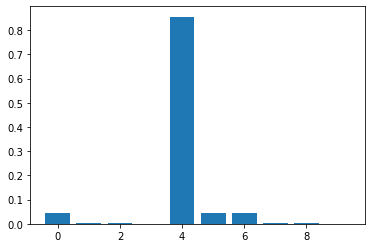

In [22]:
import matplotlib.pyplot as plt
plt.bar( np.arange(10), P_MR[:,4] / sum( P_MR[:,4] ) ) # barplot of conditional probabilities
plt.show()

Notice how the conditional probability $P(M_3|R_4)$ is much smaller than $P(M_0|R_4)$, which means that if Bob receives $R_4$, Alice is more likely to have sent $M_0$ rather than $M_3$. That's because the conditional probabilities rely on the Hamming distances of the codes, which are not necessarily similar to the numerical distances of the messages/digits. The [tesseract](https://en.wikipedia.org/wiki/Tesseract) plot below illustrates the Hamming distances of all 4-digit binary codes, given by the minimum number of hops between two node/codes.

<a title="en:User:Cburnett, CC BY-SA 3.0 &lt;http://creativecommons.org/licenses/by-sa/3.0/&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Hamming_distance_4_bit_binary_example.svg"><img width="256" alt="Hamming distance 4 bit binary example" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/Hamming_distance_4_bit_binary_example.svg/256px-Hamming_distance_4_bit_binary_example.svg.png"></a>

##### Code Performance

For overall code performance, we look at the probability of decoding the correct message, as well as the probability of errors, either *detected* or *undetected*. In our example, the overall probability (across all messages) of a correct communication is 

$$ \sum_{i=0}^{9} P( M_i \cap R_i ) $$ 

This is given by the sum of the diagonal elements of the joint probability matrix, according to the following plot:
![code_matrix](./img/3/code_matrix.svg)

In [23]:
sum( np.diag(P_MR) )

0.81450625

The probability of a *detected* error, i.e. of received code mapping to $err$, is $ \sum_{i=0}^{9} \sum_{j=10}^{15} P( M_i \cap R_j )$, which is the sum of the last 6 columns of ```P_MR```

In [24]:
np.sum( P_MR[:,10:16], axis=None)

0.048525000000000006

And the probability of an *undetected* error is the sum of the off-diagonal elements of the $10\times 10$ sub-matrix

In [25]:
np.sum( P_MR[0:10,0:10], axis=None) - sum( np.diag(P_MR) )

0.13696874999999975

There is a 13.7% chance of getting an undetenced error, i.e. receiving a code that maps to a different message (but not $err$) than the intended one. 

##### Modified Code
Now that we know how to measure code performance, we can test different coding schemes. The basic idea is to employ a coding scheme that maps messages "far apart" from each other (in an appropriate [distance function](https://en.wikipedia.org/wiki/Metric_(mathematics))) so as to minimize the probability of mixing them up. For example, let's change the coding scheme so that $9$ maps to $(1111)$, which is farther apart from the other codes in Hamming distance, and hence less likely to get mixed up. The joint probability matrix for this scheme is shown below (note the change in the last row's code):
![Modified code](./img/3/mod_code.svg)
and caclulated as:

In [26]:
P_MR_v2 = ( p ** dist_mat[ [0,1,2,3,4,5,6,7,8,15], :] ) * \
    ( (1-p) ** ( 4 - dist_mat[ [0,1,2,3,4,5,6,7,8,15], :] ) ) / 10

The overall probability of correct transmission is the same as before; this is straightforward to prove by symmetry. Therefore, the total probability of incorrent transmission is also the same, but the difference lies in the probability of detected vs silent errors. The probability of a detected error is now

In [27]:
np.sum( P_MR_v2[:,9:15] )

0.057075

and the probability of a silent error is

In [28]:
1 - sum( np.diag( P_MR_v2[:,[0,1,2,3,4,5,6,7,8,15]] ) ) - np.sum( P_MR_v2[:,9:15] )

0.12841875000000014

This is lower than the previous probability of 13.7%. The take-away is that mapping messages farther appart allows us to better detect errors.

##### Error Correction

Another common strategy is to automatically *correct* errors, by mapping mistakenly transmitted codes onto their likely original messages, which is called [forward error correction](https://en.wikipedia.org/wiki/Error_correction_code#Forward_error_correction). In the modified example above ($9 \leftrightarrow (1111)$), assume we also decode $(1110)$ onto the digit $9$, since $(1110)$ is less likely to have come from other messages (except for $6 \leftrightarrow (0110)$, but ignore this). The probability of correct transmission now includes an extra code, at the expense of inflating the probability of *silent* errors, as shown below:
![Error Correction Code](./img/3/ecc.svg) 
The probability of correct transmission is now slightly higher:

In [29]:
 sum( np.diag( P_MR_v2[:,[0,1,2,3,4,5,6,7,8,15]] ) ) + P_MR_v2[9,14]

0.8187931249999999

but the probability of a silent error also increased: 

In [30]:
np.sum(P_MR_v2[:,[0,1,2,3,4,5,6,7,8,14,15]], axis = None) - sum( np.diag( P_MR_v2[:,[0,1,2,3,4,5,6,7,8,15]] ) ) - P_MR_v2[9,14]

0.13364437499999973

##### Redundancy 
For fixed code length, there will be trade-offs between correct transmission, detected/corrected, and silent errors. But there is a way to improve *all* metrics by introducing [redundancy](https://en.wikipedia.org/wiki/Redundancy_(information_theory)), i.e. transmitting more bits that the absolutely minimum necessary. Essentially, this "expands" the space of possible codes so that you can map messages farther apart. 

But redundancy introduces also concerns of *efficiency*: for example, you could transmit a digit with miniscule probability of error using a 1000-bit code, but that would use up too much time and resources for transmitting 1000 instead of 4 bits. There is actually a celebrated [theorem](https://en.wikipedia.org/wiki/Noisy-channel_coding_theorem) that provides the optimal trade-off between the accuracy and redundancy (code length) of a channel, unfortunately without identifying the optimal code that achieves it; ironically, the theorem's proof uses *random* codes! In fact, even for "simple" setups such as the above, finding the optimal code is an [open problem](https://math.stackexchange.com/questions/4416045/how-to-find-the-maximal-minimal-distance-between-m-points-in-a-k-dimension-hammi).


### Problems

1. Assume the original setup above, i.e a binary symmetric channel ($p=.05\%$) with binary representation for the 10 digits. To minimize errors, you decide to transmit every bit in the binary representation *3 times*, and take the majority bit as received; this is an example of a [repetition code](https://en.wikipedia.org/wiki/Repetition_code). E.g., $2$ would be mapped to $(0010)$, which would be transmitted as $((000)(000)(111)(000))$. At the other end, if Bob received $( (010) (\cdots)(\cdots)(\cdots) )$, he would automatically correct $(010)$ to $0$, since 2/3 bits are $0$, etc. Find the probability of correct transmission for this scheme; this is a simple enough analytical caclulation that does not require Python. <br>
(Note: This is an extension of Execise 2.12.(b) from [B&W](https://drive.google.com/file/d/1VmkAAGOYCTORq1wxSQqy255qLJjTNvBI/view). )
2. Consider the [two-out-of-five code](https://en.wikipedia.org/wiki/Two-out-of-five_code), where each digit is mapped to a 5-bit string with two $1$'s and three $0$'s, as follows:
| Digit | Binary Code |
|:-----:|:------:|
|   1   | 00011  |
|   2   | 00101  |
|   3   | 00110  |
|   4   | 01001  |
|   5   | 01010  |
|   6   | 01100  |
|   7   | 10001  |
|   8   | 10010  |
|   9   | 10100  |
|   0   | 11000  |

There are exactly $ { 5 \choose 2 }= 10$ such codes, all either 2 or 4 bits apart in Hamming distance. Using a binary symmetric channel with $p=5\%$, calculate the probability of correct transmission, detected error, and undetected error. <br>
(Note there is no error correction in this scheme, any received code without two $1$'s is mapped to $err$).


<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.